# **Introduction to CUDA Python with Numba**

## **CONCEPT 1: What is Numba?**

Numba is a **just-in-time, type-specializing, function compiler** for accelerating **numerically-focused** Python. Let's break down those terms:

- **function compiler:** Numba compiles Python functions, not entire applications, and not parts of functions. Numba does not replace your Python interpreter, but is just another Python module that can turn a function into a (usually) faster function.
- **type-specializing:** Numba speeds up your function by generating a specialized implementation for the specific data types you are using. Python functions are designed to operate on generic data types, which makes them very flexible, but also very slow. In practice, you only will call a function with a small number of argument types, so Numba will generate a fast implementation for each set of types.
- **just-in-time:** Numba translates functions when they are first called. This ensures the compiler knows what argument types you will be using. This also allows Numba to be used interactively in a Jupyter notebook just as easily as a traditional application
- **numerically-focused:** Currently, Numba is focused on numerical data types, like int, float, and complex. There is very limited string processing support, and many string use cases are not going to work well on the GPU. To get best results with Numba, you will likely be using NumPy arrays.

The most common way to use Numba is through its collection of decorators that can be applied to your functions to instruct Numba to compile them. When a call is made to a Numba decorated function it is compiled to machine code “just-in-time” for execution and all or part of your code can subsequently run at native machine code speed!

Numba supports CUDA GPU programming by directly compiling a restricted subset of Python code into CUDA kernels and device functions following the CUDA execution model. Kernels written in Numba appear to have direct access to NumPy arrays. NumPy arrays are transferred between the CPU and the GPU automatically.

[Documentation](https://numba.readthedocs.io/en/stable/cuda/index.html)

#### **Terminology**
* **host**: the CPU
* **device**: the GPU
* **host memory**: the system main memory
* **device memory**: onboard memory on a GPU card
* **kernels**: a GPU function launched by the host and executed on the device
* **device function**: a GPU function executed on the device which can only be called from the device (i.e. from a kernel or another device function)

Most CUDA programming facilities exposed by Numba map directly to the CUDA C language offered by NVIDIA. Therefore, it is recommended you read the official [CUDA C programming guide](https://docs.nvidia.com/cuda/cuda-c-programming-guide/).

## **CONCEPT 2: How does Numba work?**

Numba reads the Python bytecode for a decorated function and combines this with information about the types of the input arguments to the function. It analyzes and optimizes your code, and finally uses the LLVM compiler library to generate a machine code version of your function, tailored to your CPU capabilities. This compiled version is then used every time your function is called.

![Numba flowcart](../numba_flowcart.png)

### **Other things of interest:**

Numba has quite a few decorators:
- `@jit` - compile the decorated function on-the-fly to produce efficient machine code. [Docs are here](https://numba.pydata.org/numba-doc/latest/reference/jit-compilation.html)
- `@njit` - this is an alias for `@jit(nopython=True)` as it is so commonly used!
- `@vectorize` - produces NumPy `ufunc` s (with all the `ufunc` methods supported). [Docs are here](https://numba.pydata.org/numba-doc/latest/user/vectorize.html#vectorize).
- `@guvectorize` - produces NumPy generalized `ufunc` s. [Docs are here](https://numba.pydata.org/numba-doc/latest/user/vectorize.html#guvectorize).
- `@stencil` - declare a function as a kernel for a stencil like operation. [Docs are here](https://numba.pydata.org/numba-doc/latest/user/stencil.html#numba-stencil).
- `@jitclass` - for jit aware classes. [Docs are here](https://numba.pydata.org/numba-doc/latest/user/jitclass.html#jitclass).
- `@cfunc` - declare a function for use as a native call back (to be called from C/C++ etc). [Docs are here](https://numba.pydata.org/numba-doc/latest/user/cfunc.html#cfunc).
- `@overload` - register your own implementation of a function for use in nopython mode, e.g. `@overload(scipy.special.j0)`. [Docs are here](https://numba.pydata.org/numba-doc/latest/extending/high-level.html#high-level-extending).





# **Tutorial: Numba Basics**

For this tutorial, we will learn how to write a Numba function and compile it for the CPU, how to create a universal Numpy functions and how to write device functions.

## **Compiling Python code with @jit**

Numba provides several utilities for code generation, but its central feature is the numba.jit() decorator with an explicit signature. Using Numba decorator @jit, which creates a normal function for execution on the CPU.

### Step 1: Import libraries

In [1]:
import numpy as np
import math
import random
from decimal import Decimal

import numba
from numba import jit
from numba import vectorize 
from numba import guvectorize
from numba import cuda

In [2]:
# Checking Numba version
print(numba.__version__)

0.53.1


### Step 2: Compiling functions on the CPU

We will write the first Numba function and compile it for the CPU. The Numba compiler is typically enabled by applying a decorator to a Python function. Decorators are functions that transform Python functions. Here we will use the CPU compilation decorator:

 Let’s start by peeking at the numba.jit string-doc:

In [3]:
print(numba.jit.__doc__)


    This decorator is used to compile a Python function into native code.

    Args
    -----
    signature_or_function:
        The (optional) signature or list of signatures to be compiled.
        If not passed, required signatures will be compiled when the
        decorated function is called, depending on the argument values.
        As a convenience, you can directly pass the function to be compiled
        instead.

    locals: dict
        Mapping of local variable names to Numba types. Used to override the
        types deduced by Numba's type inference engine.

    target (deprecated): str
        Specifies the target platform to compile for. Valid targets are cpu,
        gpu, npyufunc, and cuda. Defaults to cpu.

    pipeline_class: type numba.compiler.CompilerBase
            The compiler pipeline type for customizing the compilation stages.

    options:
        For a cpu target, valid options are:
            nopython: bool
                Set to True to disable the use

The recommended way to use the @jit decorator is to let Numba decide when and how to optimize. Let's make a compiled version of a function. In this mode, compilation will be deferred until the first function execution. Numba will infer the argument types at call time, and generate optimized code based on this information.

In [4]:
nsamples = 2000
# JIT compile a python function conforming to the CUDA-Python specification. To define a CUDA kernel:
@jit
def monte_carlo_pi(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x**2 + y**2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

### Step 3: Benchmarking

Measuring the performance of your new code is an important part. Let's see if we actuall speed up between the compiled and uncompiled versions. The easiest way to do is in the Jupyter notebook is to use **%timeit** function.
 **.py_func** attribute that can be used to access the original uncompiled Python function.

In [5]:
%timeit monte_carlo_pi.py_func(nsamples)

2.44 ms ± 17.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
%timeit monte_carlo_pi(nsamples)

100 µs ± 38.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


The Numba-compiled version had a significant speed-up with this function!

### **Signature specifications**

In order to generate fast code, the compiler needs type information for the code. This allows a direct mapping from the Python operations to the appropriate machine instruction without any type check/dispatch mechanism. 

Explicit `@jit` signatures can use a number of types. Here are some common ones:

- `void` is the return type of functions returning nothing (which actually return `None` when called from Python)
- `intp` and `uintp` are pointer-sized integers (signed and unsigned, respectively)
- `intc` and `uintc` are equivalent to C `int` and `unsigned int` integer types
- `int8`, `uint8`, `int16`, `uint16`, `int32`, `uint32`, `int64`, `uint64` are fixed-width integers of the corresponding bit width (signed and unsigned)
- `float32` and `float64` are single- and double-precision floating-point numbers, respectively
- `complex64` and `complex128` are single- and double-precision complex numbers, respectively
- array types can be specified by indexing any numeric type, e.g. `float32[:]` for a one-dimensional single-precision array or `int8[:,:]` for a two-dimensional array of 8-bit integers.



### Step 4: Compilation options

The Numba @jit decorator fundamentally operates in two compilation modes:
- `nopython mode`
- `object mode`

The behaviour of the **nopython** compilation mode is to essentially compile the decorated function so that it will run entirely without the involvement of the Python interpreter. This is the recommended and best-practice way to use the Numba jit decorator as it leads to the best performance.

Should the compilation in **nopython mode** fail, Numba can compile using **object mode**. This is a fall back mode for the @jit decorator if **nopython=True** is not set. In this mode Numba will identify loops that it can compile and compile those into functions that run in machine code, and it will run the rest of the code in the interpreter. For best performance avoid using this mode!

Numba cannot compile all Python code. Some functions don't have a Numba-translation, and some kinds of Python types can't be efficiently compiled at all (yet). For example, Numba does not support dictionaries (as of this tutorial):

In [9]:
from numba import jit

@jit(forceobj=True)  # Allows object mode
def cannot_compile(x):
    return x['key']

print(cannot_compile(dict(key='value')))

value


By default, Numba will fall back to a mode, called "object mode," which does not do type-specialization. Object mode exists to enable other Numba functionality, but in many cases, you want Numba to tell you if type inference fails. You can force "nopython mode" (the other compilation mode) by passing arguments to the decorator:

Let's see nopython mode. The nopython mode will generate the best performance, but has limitations.

In [10]:
#function without error
@jit("void(f4[:])",nopython=True)
def squared(a):
    squared_val = a*a


Types that can’t be inferred by the compiler in the nopython mode and it will generate an error.

In [12]:
#function that contains a variable whose type can’t be inferred by the compiler
#nopython mode set to True

@jit("void(f4[:])",nopython=True)
def squared(a):
    squared_val = a*a
    val = 100.00

If we don’t specify anything like in the function below, where nopython mode is not set to True, the compilation is falling back to object mode and produces a warning but not an error.

In [17]:
# function that contains a variable whose type can’t be inferred by the compiler
# nopython mode not set to True
# compilation is falling back to object mode

@jit("void(f4[:])")
def squared(a):
    squared_val = a*a
    val = 100.00

### Step 4: Type inference

The objective of type inference is assigning a type to every single value in the function. The type of a value can either be:

* Implicit, in the case of providing an object that will provide its type. For e.g. in literals.
* Explicit, in the case of the programmer explicitly writing the type of a given value. For e.g. when a signature is given to numba.jit. That signature explicitly types the arguments.
* Inferred, when the type is deduced from an operation and the types of its operands. For e.g. inferring that the type of a + b, when a and b are of type int is going to be an int
Type inference is the process by which all the types that are neither implicit nor explicit are deduced.

In [15]:
# Let’s illustrate how type inference works with numba.jit. 
# We can see the result of type inference by using the .inspect_types() method, which prints an annotated version of the source code.

monte_carlo_pi.inspect_types()

monte_carlo_pi (int64,)
--------------------------------------------------------------------------------
# File: <ipython-input-4-70a9c87dfcd7>
# --- LINE 3 --- 

@jit

# --- LINE 4 --- 

def monte_carlo_pi(nsamples):

    # --- LINE 5 --- 
    # label 0
    #   nsamples = arg(0, name=nsamples)  :: int64
    #   acc = const(int, 0)  :: Literal[int](0)

    acc = 0

    # --- LINE 6 --- 
    #   jump 6
    # label 6
    #   jump 8
    # label 8
    #   $8.1 = global(range: <class 'range'>)  :: Function(<class 'range'>)
    #   $8.3 = call $8.1(nsamples, func=$8.1, args=[Var(nsamples, <ipython-input-4-70a9c87dfcd7>:5)], kws=(), vararg=None)  :: (int64,) -> range_state_int64
    #   del $8.1
    #   $8.4 = getiter(value=$8.3)  :: range_iter_int64
    #   del $8.3
    #   $phi16.1 = $8.4  :: range_iter_int64
    #   del $8.4
    #   jump 16
    # label 16
    #   $16.2 = iternext(value=$phi16.1)  :: pair<int64, bool>
    #   $16.3 = pair_first(value=$16.2)  :: int64
    #   $16.4 = pair_se

Note that Numba's type names tend to mirror the NumPy type names, so a Python float is a float64 (also called "double precision" in other languages). Taking a look at the data types can sometimes be important in GPU code because the performance of float32 and float64 computations will be very different on CUDA devices. An accidental upcast can dramatically slow down a function.

## **Creating Numpy universal functions**

#### **CUDA Basics**

There are two basic approaches to GPU programming in Numba:

- ufuncs/gufuncs
- CUDA Python kernels. [See documentation here](https://numba.pydata.org/numba-doc/latest/cuda/kernels.html)

We will not go into the CUDA hardware too much in this section, but the most important thing to remember is that the hardware is designed for data parallelism. Maximum throughput is achieved when you are computing the same operations on many different elements at once.

Universal functions are naturally data parallel, so we will begin with them.

#### **Universal Functions** 

Numba supports generating two types of universal functions:

- Those which operate on scalars, these are “universal functions” or ufuncs (@vectorize below).
- Those which operate on higher dimensional arrays and scalars, these are “generalized universal functions” or gufuncs (@guvectorize below).

#### **Universal functions**

Universal functions(ufuncs) are functions that broadcast an elementwise operation across input arrays of varying numbers of dimensions. Most NumPy functions are ufuncs, and Numba makes it easy to compile custom ufuncs using the @vectorize decorator.

#### Step 1: 

The NumPy documentation has a much more extensive discussion of ufuncs:

https://docs.scipy.org/doc/numpy/reference/ufuncs.html

In [18]:
# Applying sqrt() method in Numpy
def cpu_sqrt(x):
  return math.sqrt(x)

In [19]:
# Making ufuncs for the CPU
@vectorize
def cpu_numba_sqrt(x):
  return math.sqrt(x)

In [20]:
# Making a ufunc for the GPU
# Generating a ufunc that uses CUDA requires giving an explicit type signature and setting the target attribute
@vectorize(['float32(float32)'], target='cuda')
def gpu_numba_sqrt(x):
    return math.sqrt(x)

In [21]:
%timeit np.sqrt(25) # NumPy on CPU

6.52 µs ± 55.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [22]:
%timeit cpu_sqrt(25)  # NumPy on CPU

698 ns ± 15.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [23]:
%timeit cpu_numba_sqrt(25) # Numba on CPU

4.2 µs ± 27.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [24]:
%timeit gpu_numba_sqrt(25) # Numba on GPU

3.71 ms ± 333 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Why did we see an increase in the processing time?

An overhead is introduced by Numba to each function call that is larger than the function call overhead of Python itself. 

Functions that are quick to compute are affected by this.

Since the function here is too simple to run on the GPU, we experience longer processing time due to data transfer operations taking place.

* input data is transferred to the GPU memory
* the square root is calculated on the GPU
* the resulting value is sent back to the host system

#### **Generalized ufuncs on the GPU**

In generalized ufuncs (gufuncs), the calculation can deal with a sub-array of the input array, and return an array of different dimensions.

In [25]:
#calculating the sum of elements in each row of the array
@guvectorize(['(float32[:], float32[:])'],
             '(n)->()',                
             target='cuda')
def calc_sum(a, out):
    sum = 0
    for val in a: 
        sum += val
    out[0] = sum

In [26]:
a = np.arange(50).reshape(10, 5).astype(np.float32)
a

array([[ 0.,  1.,  2.,  3.,  4.],
       [ 5.,  6.,  7.,  8.,  9.],
       [10., 11., 12., 13., 14.],
       [15., 16., 17., 18., 19.],
       [20., 21., 22., 23., 24.],
       [25., 26., 27., 28., 29.],
       [30., 31., 32., 33., 34.],
       [35., 36., 37., 38., 39.],
       [40., 41., 42., 43., 44.],
       [45., 46., 47., 48., 49.]], dtype=float32)

In [27]:
calc_sum(a)

array([ 10.,  35.,  60.,  85., 110., 135., 160., 185., 210., 235.],
      dtype=float32)

## **CUDA Device Functions**

Uptil now we were compiling all our code in single functions and ufuncs are great, but you should not have to cram all of your logic into a single function body. You can also create normal functions that are only called from other functions running on the GPU. These are called **device** functions.(These are similar to CUDA C functions defined with __device__.)

Device functions are created with the numba.cuda.jit decorator:

`add_values:` device function to sum up the elements of the array using the numba.cuda.jit decorator

`calc_sum:` gufunc to make use of the add_values device function

`calc_avg:` gufunc to calculate the average

In [28]:
# define a device function
@cuda.jit(device=True)
def add_values(a): 
  sum = 0
  for val in a: 
    sum += val
  return sum

# define a gufunc that calls our device function
@guvectorize(['(float32[:], float32[:])'],
             '(n)->()',                
             target='cuda')
def calc_sum(a, out):
    out[0] = add_values(a)

@guvectorize(['(float32[:], float32[:])'],
             '(n)->()',                
             target='cuda')
def calc_avg(a, out):
    out[0] = add_values(a)/len(a)

In [29]:
calc_sum(a)

array([ 10.,  35.,  60.,  85., 110., 135., 160., 185., 210., 235.],
      dtype=float32)

In [30]:
calc_avg(a)

array([ 2.,  7., 12., 17., 22., 27., 32., 37., 42., 47.], dtype=float32)

# **Exercise: Numba Basics**

The function below is a naive sum function that sums all the elements of a given array. Let’s get a numba version of this code running.

In [31]:
#Write your own code

# Naive sum function
def naive_sum(arr):
    total = 0.0
    for val in arr:
        total += val
    return total

# Optimized Numba version
@jit(nopython=True)
def numba_sum(arr):
    total = 0.0
    for val in arr:
        total += val
    return total

# Test the functions
arr = np.random.rand(1_000_000)  # Large array

# Timing the functions
%timeit naive_sum(arr)   # Without Numba
%timeit numba_sum(arr)   # With Numba


895 ms ± 7.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.83 ms ± 9.68 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


##### **As a function call**

Compile **summation_array()** function using numba.jit without providing a type-signature for the function.

In [32]:
# Write your own code
@jit(nopython=True)  # No type signature provided
def summation_array(arr):
    total = 0.0
    for val in arr:
        total += val
    return total

# Generate a random array
arr = np.random.rand(1_000_000)

# Function call
result = summation_array(arr)

# Print the result
print("Summation Result:", result)

# Measure performance
%timeit summation_array(arr)

Summation Result: 500014.2972769471
3.85 ms ± 10.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


##### **As a decorater**

In [33]:
# Write your own code

@jit(nopython=True)
def summation_array(arr):
    total = 0.0
    for val in arr:
        total += val
    return total

arr = np.random.rand(1_000_000)

# Call the function
result = summation_array(arr)

# Print result
print("Summation Result:", result)

# Performance measurement
%timeit summation_array(arr)

Summation Result: 499457.60266747046
3.79 ms ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


##### **Benchmarking**

Compare NumPy and Numba using %timeit

In [34]:
# Write your own code

arr = np.random.rand(1_000_000)

# Naive Python summation function
def python_sum(arr):
    total = 0.0
    for val in arr:
        total += val
    return total

# Numba JIT-optimized summation function
@jit(nopython=True)
def numba_sum(arr):
    total = 0.0
    for val in arr:
        total += val
    return total

# Benchmarking with %timeit
print("Benchmarking Performance:")

# Naive Python function
%timeit python_sum(arr)  # Slowest

# NumPy built-in sum
%timeit np.sum(arr)  # Highly optimized

# Numba JIT-compiled sum
%timeit numba_sum(arr)  # Fastest (near NumPy speed)

Benchmarking Performance:
881 ms ± 20.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.25 ms ± 36.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.84 ms ± 20.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


##### **Question: When does Numba compile codes?**

Numba compiles code at runtime (JIT compilation), optimizing functions when they are first called with a specific set of input types. It caches the compiled version for reuse, making subsequent calls faster unless the input types change, which triggers a new compilation. This allows for high-performance execution without manual type specification.

# **Tutorial: Memory Management**

In order to reduce the impact of host-to-device/device-to-host bandwidth, it is best to copy data to the GPU explicitly and leave it there to amortize the cost over multiple function calls. In addition, allocating device memory can be relatively slow, so allocating GPU arrays once and refilling them with data from the host can also be a performance improvement.



In [35]:
@vectorize(['float32(float32, float32)'], target='cuda')
def add_ufunc(x, y):
    return x + y

In [36]:
n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x

In [37]:
%timeit add_ufunc(x, y)  # Baseline performance with host arrays

9.15 ms ± 641 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


The numba.cuda module includes a function that will copy host data to the GPU and return a CUDA device array:

In [38]:
from numba import cuda

x_device = cuda.to_device(x)
y_device = cuda.to_device(y)

print(x_device)
print(x_device.shape)
print(x_device.dtype)

(100000,)
float32


Device arrays can be passed to CUDA functions just like NumPy arrays, but without the copy overhead:

In [39]:

%timeit add_ufunc(x_device, y_device)

2.8 ms ± 48.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


That's a big performance improvement already, but we are still allocating a device array for the output of the ufunc and copying it back to the host. We can create the output buffer with the numba.cuda.device_array() function:

In [40]:
out_device = cuda.device_array(shape=(n,), dtype=np.float32)  # does not initialize the contents, like np.empty()

And then we can use a special out keyword argument to the ufunc to specify the output buffer:

In [41]:
%timeit add_ufunc(x_device, y_device, out=out_device)

1.73 ms ± 22 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Now that we have removed the device allocation and copy steps, the computation runs much faster than before. When we want to bring the device array back to the host memory, we can use the copy_to_host() method:

In [42]:
out_host = out_device.copy_to_host()
print(out_host[:10])

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


# **Tutorial: Writing CUDA kernels**

Ufuncs and generalized ufuncs are the easiest way in Numba to use the GPU, and present an abstraction that requires minimal understanding of the CUDA programming model. However, you can not write all functions as ufuncs so you write a CUDA kernel.

It's highly recommend to read Chapters 1 and 2 of the CUDA C Programming Guide to understand how to write CUDA kernels with Numba.
- Introduction: http://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#introduction
- Programming Model: http://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#programming-model

![[cuda flowchart](https://camo.githubusercontent.com/87204582bdb0422a08cef47cd0bafcfd860cd522/687474703a2f2f646f63732e6e76696469612e636f6d2f637564612f637564612d632d70726f6772616d6d696e672d67756964652f67726170686963732f677269642d6f662d7468726561642d626c6f636b732e706e67)](https://camo.githubusercontent.com/87204582bdb0422a08cef47cd0bafcfd860cd522/687474703a2f2f646f63732e6e76696469612e636f6d2f637564612f637564612d632d70726f6772616d6d696e672d67756964652f67726170686963732f677269642d6f662d7468726561642d626c6f636b732e706e67)

We will write a *kernel* that decribes the execution of a single thread in this hierarchy. The CUDA compiler and driver will execute the kernel across a *thread grid* that is divided into *blocks* of threads. Threads within the same block can exchange data very easily during the execution of a kernel, whereas threads in different blocks should generally not communicate with each other (with a few exceptions).

Deciding the best size for the CUDA thread grid is a complex problem (and depends on both the algorithm and the specific GPU compute capability), but here are some very rough heuristics that we follow:

- the size of a block should be a multiple of 32 threads, with typical block sizes between 128 and 512 threads per block.
- the size of the grid should ensure the full GPU is utilized where possible. Launching a grid where the number of blocks is 2x-4x the number of "multiprocessors" on the GPU is a good starting place. Something in the range of 20 - 100 blocks is usually a good starting point.
- The CUDA kernel launch overhead does depend on the number of blocks, so we find it best not to launch a grid where the number of threads equals the number of input elements when the input size is very big. We'll show a pattern for dealing with large inputs below.

Each thread distinguishes itself from the other threads using its unique thread (`threadIdx`) and block (`blockIdx`) index values, which can be multidimensional if launched that way.



### Step 1: Getting Started

In this section, you will learn how to write your own custom CUDA kernels to do accelerated, parallel computing on a GPU, in python with the help of numba and CUDA.


In [43]:
from numba import cuda

### Step 2: Write a CUDA kernel

CUDA kernels are compiled using the numba.cuda.jit decorator (not to be confused with the numba.jit decorator for the CPU).

In [44]:
@cuda.jit
def add_kernel(x, y, out):
    tx = cuda.threadIdx.x # this is the unique thread ID within a 1D block
    ty = cuda.blockIdx.x  # Similarly, this is the unique block ID within the 1D grid

    block_size = cuda.blockDim.x  # number of threads per block
    grid_size = cuda.gridDim.x    # number of blocks in the grid
    
    start = tx + ty * block_size
    stride = block_size * grid_size

    # assuming x and y inputs are same length
    for i in range(start, x.shape[0], stride):
        out[i] = x[i] + y[i]

### Step 3: Call the function


In [45]:
import numpy as np

n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x
out = np.empty_like(x)

threads_per_block = 128
blocks_per_grid = 30

add_kernel[blocks_per_grid, threads_per_block](x, y, out)
print(out[:10])

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


### Step 4: Copy host data to the GPU and return a CUDA device array

In [46]:
x_device = cuda.to_device(x)
y_device = cuda.to_device(y)
out_device = cuda.device_array_like(x)

In [47]:
%timeit add_kernel[blocks_per_grid, threads_per_block](x, y, out)

10.8 ms ± 364 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [48]:
%timeit add_kernel[blocks_per_grid, threads_per_block](x_device, y_device, out_device); out_device.copy_to_host()

1.26 ms ± 46 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Kernel Synchronization

CUDA kernel execution is designed to be asynchronous with respect to the host program. This means that the kernel launch (add_kernel[blocks_per_grid, threads_per_block](x_device, y_device, out_device)) returns immediately, allowing the CPU to continue executing while the GPU works in the background. Only host<->device memory copies or an explicit synchronization call will force the CPU to wait until previously queued CUDA kernels are complete.

Always be sure to synchronize with the GPU when benchmarking CUDA kernels!

In [49]:
# CPU input/output arrays, implied synchronization for memory copies
%time add_kernel[blocks_per_grid, threads_per_block](x, y, out)

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 14.2 ms


In [50]:
# GPU input/output arrays, no synchronization (but force sync before and after)
cuda.synchronize()
%time add_kernel[blocks_per_grid, threads_per_block](x_device, y_device, out_device)
cuda.synchronize()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.1 ms


In [51]:
# GPU input/output arrays, include explicit synchronization in timing
cuda.synchronize()
%time add_kernel[blocks_per_grid, threads_per_block](x_device, y_device, out_device); cuda.synchronize()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.07 ms


# **Exercise: Writing CUDA kernels**

Below statement is a pure Python implementation of a function. 

In [52]:
# Python implementation
def mandelbrot(x, y, max_iters):
  i = 0
  c = complex(x,y)
  z = 0.0j
  for i in range(max_iters):
    z = z * z + c
    if z.real * z.real + z.imag * z.imag >= 4:
        return i
  return 255

Step 1: Modify the example by compiling:
- @jit decorator, to run as native code on the CPU
- @cuda.jit decorator, to run on the GPU

In [53]:
# Write your own code here

@jit(nopython=True)
def mandelbrot_cpu(x, y, max_iters):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z * z + c
        if z.real * z.real + z.imag * z.imag >= 4:
            return i
    return 255

# Test CPU function
print(mandelbrot_cpu(0.5, 0.5, 100))

4


In [55]:
@cuda.jit
def mandelbrot_gpu(x, y, max_iters, output):
    i, j = cuda.grid(2)
    if i < output.shape[0] and j < output.shape[1]:  # Ensure within bounds
        c = complex(x[i, j], y[i, j])
        z = 0.0j
        count = 0
        for count in range(max_iters):
            z = z * z + c
            if z.real * z.real + z.imag * z.imag >= 4:
                break
        output[i, j] = count


Step 2: Copy host data to the GPU and return a CUDA device array

In [57]:
# Write your own code here

import numpy as np
import matplotlib.pyplot as plt
from numba import cuda, jit

# Step 1: CPU Implementation using @jit for speedup
@jit(nopython=True)
def mandelbrot_cpu(x, y, max_iters):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z * z + c
        if z.real * z.real + z.imag * z.imag >= 4:
            return i
    return max_iters

# Step 2: GPU Kernel
@cuda.jit
def mandelbrot_gpu(x, y, max_iters, output):
    i, j = cuda.grid(2)
    if i < output.shape[0] and j < output.shape[1]:  # Check within bounds
        c = complex(x[i, j], y[i, j])
        z = 0.0j
        count = 0
        for count in range(max_iters):
            z = z * z + c
            if z.real * z.real + z.imag * z.imag >= 4:
                break
        output[i, j] = count

# Step 3: Copy Data to GPU
def copy_to_gpu(host_array):
    return cuda.to_device(host_array)

# Step 4: Main Execution
def main():
    # Define grid size
    width, height = 1000, 1000  # Higher values for better resolution
    max_iters = 255

    # Create coordinate arrays
    x = np.linspace(-2.0, 1.0, width, dtype=np.float32)
    y = np.linspace(-1.5, 1.5, height, dtype=np.float32)
    X, Y = np.meshgrid(x, y)

    # Allocate output array
    output = np.zeros((width, height), dtype=np.int32)

    # Copy data to GPU
    d_X = copy_to_gpu(X)
    d_Y = copy_to_gpu(Y)
    d_output = copy_to_gpu(output)

    # Define grid and block dimensions
    threads_per_block = (16, 16)
    blocks_per_grid_x = (width + threads_per_block[0] - 1) // threads_per_block[0]
    blocks_per_grid_y = (height + threads_per_block[1] - 1) // threads_per_block[1]
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    # Launch CUDA Kernel
    mandelbrot_gpu[blocks_per_grid, threads_per_block](d_X, d_Y, max_iters, d_output)

    # Copy result back to CPU
    result = d_output.copy_to_host()

    # Plot the Mandelbrot set
    plt.figure(figsize=(10, 10))
    plt.imshow(result, extent=(-2, 1, -1.5, 1.5), cmap='inferno')
    plt.colorbar()
    plt.title("Mandelbrot Set (GPU Accelerated)")
    plt.show()

# Run the program
if __name__ == "__main__":
    main()


In [56]:
pip install numpy numba matplotlib

Note: you may need to restart the kernel to use updated packages.


Step 3: Can you also rewrite the mandel function using @vectorize for the CUDA target?

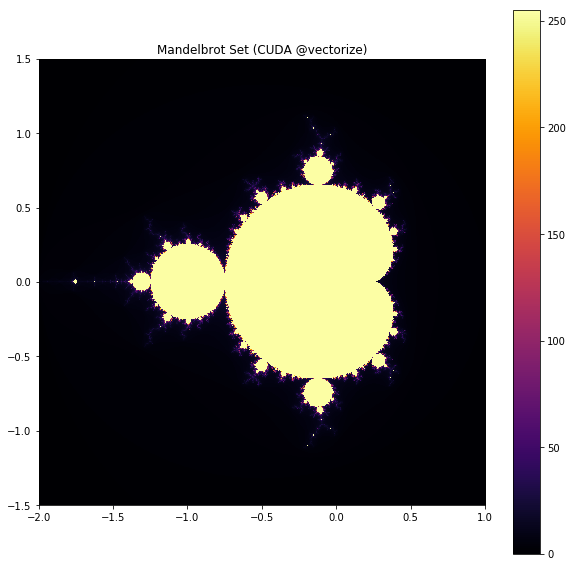

In [59]:
# Write your own code here

import numpy as np
import matplotlib.pyplot as plt
from numba import vectorize, cuda

# Step 3: Vectorized Mandelbrot function for CUDA
@vectorize(["int32(float32, float32, int32)"], target="cuda")
def mandelbrot_vectorized(x, y, max_iters):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z * z + c
        if z.real * z.real + z.imag * z.imag >= 4:
            return i
    return max_iters

# Step 4: Main Execution
def main():
    # Define grid size
    width, height = 1000, 1000  # Higher values for better resolution
    max_iters = 255

    # Create coordinate arrays
    x = np.linspace(-2.0, 1.0, width, dtype=np.float32)
    y = np.linspace(-1.5, 1.5, height, dtype=np.float32)
    X, Y = np.meshgrid(x, y)

    # Compute Mandelbrot using vectorized function (CUDA accelerated)
    result = mandelbrot_vectorized(X, Y, max_iters)

    # Plot the Mandelbrot set
    plt.figure(figsize=(10, 10))
    plt.imshow(result, extent=(-2, 1, -1.5, 1.5), cmap='inferno')
    plt.colorbar()
    plt.title("Mandelbrot Set (CUDA @vectorize)")
    plt.show()

# Run the program
if __name__ == "__main__":
    main()
